* 将 'Monarch [no longer operating]'(放入到dev中) 替换为 'LAN Airlines (now LATAM Airlines)' 主要去预测 'WOW air [no longer operating]'
* 由lgb3修改而来，只是修改参数

In [40]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import gzip
import os
import warnings
import random
import graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization
from graphviz import Digraph

%matplotlib inline

In [41]:
df = pd.read_csv("./merge_result.csv")
print(df.info())
df = df.loc[df['is_defunct'].notnull()]

test_company = ['Primera Air [no longer operating]', 'WOW air [no longer operating]', 'LAN Airlines (now LATAM Airlines)', 'Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan',  'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air', 'tigerair australia', 'Air Madagascar', 'Southwest Airlines', 'Nouvel Air Tunise', 'TAROM', 'Wings Air', 'British Airways']
test = df[df['companyName'].isin(test_company)]
train = df[~df['companyName'].isin(test_company)]
y_train = train['is_defunct']
X_train = train.drop(columns=['is_defunct'])
y_test = test['is_defunct']
X_test = test.drop(columns=['is_defunct'])

features = list(X_train.columns)
del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
for col in del_cols:
    features.remove(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21541 entries, 0 to 21540
Columns: 176 entries, companyName to entertainment_rp
dtypes: float64(167), int64(1), object(8)
memory usage: 28.9+ MB
None


In [42]:
param = { #修改过的
    "boosting": "gbdt",
    'objective':'binary',
    'scale_pos_weight': 15,
#     'metric': ('auc', 'binary_logloss'),
    'metric': 'binary_logloss',
    'learning_rate': 0.001,
    'num_leaves': 6, # 6
    'min_data_in_leaf': 200, #120
    'max_depth': 5,                        
    "feature_fraction": 0.60279441778009675,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 0.94918097174380245 ,
    "bagging_seed": 11,
    "lambda_l1": 3.0031581969835157,
    "verbosity": -1,        
}

In [43]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
evals_result = {}  #记录训练结果所用

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx])

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    evals_result=evals_result,   #非常重要的参数,一定要明确设置
                    verbose_eval=500,
                    early_stopping_rounds=200
    )
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.139597	valid_1's binary_logloss: 0.1368
[1000]	training's binary_logloss: 0.121228	valid_1's binary_logloss: 0.119558
[1500]	training's binary_logloss: 0.102831	valid_1's binary_logloss: 0.10158
[2000]	training's binary_logloss: 0.0874277	valid_1's binary_logloss: 0.0861178
[2500]	training's binary_logloss: 0.0743414	valid_1's binary_logloss: 0.0730352
[3000]	training's binary_logloss: 0.063355	valid_1's binary_logloss: 0.0620091
[3500]	training's binary_logloss: 0.0547759	valid_1's binary_logloss: 0.0535198
[4000]	training's binary_logloss: 0.0478316	valid_1's binary_logloss: 0.0466817
[4500]	training's binary_logloss: 0.0419948	valid_1's binary_logloss: 0.0409792
[5000]	training's binary_logloss: 0.0369926	valid_1's binary_logloss: 0.0360995
[5500]	training's binary_logloss: 0.0327826	valid_1's binary_logloss: 0.0320101
[6000]	training's binary_logloss: 0.0291563	valid_1's binar

[8500]	training's binary_logloss: 0.0184538	valid_1's binary_logloss: 0.0198921
[9000]	training's binary_logloss: 0.017118	valid_1's binary_logloss: 0.0184735
[9500]	training's binary_logloss: 0.0159482	valid_1's binary_logloss: 0.0172261
[10000]	training's binary_logloss: 0.0149163	valid_1's binary_logloss: 0.0161498
[10500]	training's binary_logloss: 0.0140036	valid_1's binary_logloss: 0.0152354
[11000]	training's binary_logloss: 0.0131666	valid_1's binary_logloss: 0.0143876
[11500]	training's binary_logloss: 0.0124327	valid_1's binary_logloss: 0.013675
[12000]	training's binary_logloss: 0.0117703	valid_1's binary_logloss: 0.0130409
[12500]	training's binary_logloss: 0.0111434	valid_1's binary_logloss: 0.0124306
[13000]	training's binary_logloss: 0.0105773	valid_1's binary_logloss: 0.0119054
[13500]	training's binary_logloss: 0.0100659	valid_1's binary_logloss: 0.0114412
[14000]	training's binary_logloss: 0.00959588	valid_1's binary_logloss: 0.011009
[14500]	training's binary_logloss

[17000]	training's binary_logloss: 0.00633417	valid_1's binary_logloss: 0.00780602
[17500]	training's binary_logloss: 0.00609264	valid_1's binary_logloss: 0.00763023
[18000]	training's binary_logloss: 0.00585484	valid_1's binary_logloss: 0.00746659
[18500]	training's binary_logloss: 0.00563447	valid_1's binary_logloss: 0.00732441
[19000]	training's binary_logloss: 0.0054299	valid_1's binary_logloss: 0.0071956
[19500]	training's binary_logloss: 0.00524596	valid_1's binary_logloss: 0.00707998
[20000]	training's binary_logloss: 0.00507902	valid_1's binary_logloss: 0.00697722
Did not meet early stopping. Best iteration is:
[20000]	training's binary_logloss: 0.00507902	valid_1's binary_logloss: 0.00697722


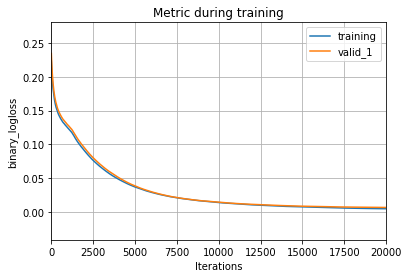

In [44]:
lgb.plot_metric(evals_result, metric='binary_logloss')#metric的值与之前的params里面的值对应

KeyError: 'No given metric in eval results.'

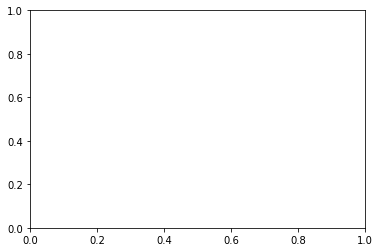

In [45]:
lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应

In [ ]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    print(thresholds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savepath:
        plt.savefig(savepath)
    plt.close(0)

draw_ROC_curve(y_train, oof)

In [ ]:
draw_ROC_curve(y_test, predictions)

In [ ]:
new_test = pd.concat([test[['companyName', 'DOW']].reset_index(), pd.Series(predictions, name='pred')], axis=1)
new_test_company = ['Primera Air [no longer operating]', 'LAN Airlines (now LATAM Airlines)', 'WOW air [no longer operating]']
new_test = new_test[new_test['companyName'].isin(new_test_company)]

display(new_test.sort_values(['companyName', 'pred'], ascending=False))
new_test.sort_values(['companyName', 'pred'], ascending=False).to_csv('./score_rank.csv')
# display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']))

In [ ]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

In [ ]:
new_train = pd.concat([train[['companyName', 'DOW']].reset_index(), pd.Series(oof, name='pred')], axis=1)
# new_train_company = ['Monarch [no longer operating]']
# new_train = new_train[new_train['companyName'].isin(new_train_company)]

display(new_train.sort_values('pred', ascending=False))
new_train.sort_values('pred', ascending=False).to_csv('./train_score_rank.csv')
# display(new_train.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))